In this notebook, I cluster the stations using the selected variables.

# Staging

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from math import pi, ceil, floor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import contextily as cx

In [2]:
sns.set(style="darkgrid")

# Import and Prep Data

## Selected features for clustering

In [3]:
# Data on selected features
exp_var_select = pd.read_csv('outputs/stn_data/features_and_cluster/exp_var_select.csv')
exp_var_select = exp_var_select.rename({'Unnamed: 0': 'StationName'}, axis=1).\
    set_index('StationName')

# Re-arrange columns
exp_var_select = exp_var_select[['residential','pop_density',
                                 'jobs_density', 'retail', 'instit_communal_accom',
                                 'btwn_centrality']]

select_var = exp_var_select.columns

In [4]:
exp_var_select.head()

residential   pop_density   jobs_density    retail  \
StationName                                                        
Acton Town       0.105412   6892.901620   12252.574201  0.011962   
Aldgate          0.127112  11821.242915  205097.660671  0.020554   
Aldgate East     0.129033  14099.574178  152530.824175  0.017154   
Alperton         0.124641   7951.186671    7080.355819  0.009463   
Amersham         0.017046   2040.327625    2178.407995  0.000729   

              instit_communal_accom  btwn_centrality  
StationName                                           
Acton Town                 0.001843         0.113110  
Aldgate                    0.002926         0.000291  
Aldgate East               0.002834         0.010971  
Alperton                   0.001669         0.031887  
Amersham                   0.000259         0.000000

## Demand  and concentration data

In [5]:
# Throughput, entry and exit data
throughput = pd.read_csv('outputs/stn_data/demand/stn_ts_throughput.csv',
                         index_col='StationName')
entry = pd.read_csv('outputs/stn_data/demand/stn_ts_entry.csv',
                    index_col='EntryStationName')
exit = pd.read_csv('outputs/stn_data/demand/stn_ts_exit.csv',
                   index_col='ExitStationName')

In [6]:
# Range standardize demand data for plotting purpose

# Define helper function
def MinMax_Std(df):

    df_std = df.copy()
    df_std = df_std.subtract(df_std.min(axis=1), axis=0)\
        .divide(df_std.max(axis=1) - df_std.min(axis=1), axis=0)\
        .combine_first(df_std)

    return df_std


# Standardize data
throughput_std = MinMax_Std(throughput)
entry_std = MinMax_Std(entry)
exit_std = MinMax_Std(exit)

In [7]:
# Import operating hours mapper
df_time = pd.read_csv('outputs/stn_data/others/operating_hours.csv')

# Labels of slots
slots_map = {'slot_'+str(df_time.loc[i, 'timeslot']):
             df_time.loc[i, 'entrytime_start']
             for i in range(len(df_time))}

throughput_std.columns = throughput_std.columns.map(slots_map)
entry_std.columns = entry_std.columns.map(slots_map)
exit_std.columns = exit_std.columns.map(slots_map)

In [8]:
# Concentration data
stn_conc = pd.read_csv('outputs/stn_data/concentration/stn_conc_throughput.csv')

## Geometry data

In [9]:
# Geometry of stations and lines
stations_gdf = gpd.read_file('outputs/stn_data/geometry/stations_gdf.gpkg')
lines_gdf = gpd.read_file('outputs/stn_data/geometry/lines_gdf.gpkg')

bng_crs = stations_gdf.crs

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [10]:
# Local authorities 
# https://geoportal.statistics.gov.uk/datasets/fef73aeaf13c417dadf2fc99abcf8eef/explore?layer=0&location=51.640057%2C-0.511728%2C10.50
# Accessed: 21 July 2022

la_gdf = gpd.read_file('data/features/lad_boundaries.zip!Local_Authority_Districts_(December_2018)_Boundaries_UK_BFC.shp')
la_gdf = la_gdf[['lad18cd', 'lad18nm', 'geometry']]

In [11]:
# Inner London
inner_london = ['Camden', 'Hackney', 'Hammersmith and Fulham',
                'Islington', 'Kensington and Chelsea', 'Lambeth', 
                'Lewisham', 'Southwark', 'Tower Hamlets', 'Wandsworth',
                'Westminster', 'City of London', 'Haringey', 'Newham']

inner_london_gdf = la_gdf[la_gdf['lad18nm'].isin(inner_london)]
inner_london_gdf = gpd.GeoDataFrame(gpd.GeoSeries(data=inner_london_gdf.unary_union,
                                                  crs='epsg:27700')).\
    rename(columns={0: 'inner'})
inner_london_gdf = inner_london_gdf.set_geometry('inner')

In [12]:
# Central Activities Zone
# Central Activity Zone
# https://data.london.gov.uk/dataset/central_activities_zone
# Accessed: 21 July 2021

caz_gdf = gpd.read_file('data/features/central_activities_zone.gpkg')
caz_gdf = gpd.GeoDataFrame(gpd.GeoSeries(data=caz_gdf.unary_union, crs='epsg:27700')).\
    rename(columns={0: 'caz'})
caz_gdf = caz_gdf.set_geometry('caz')

# Cluster Stations

## Standardize data

In [13]:
# Set up scaler
scaler = StandardScaler()

In [14]:
# Standardize data
exp_var_std = exp_var_select.copy()
for i in exp_var_std.columns:
    exp_var_std[i] = scaler.fit_transform(exp_var_std[i].values.reshape(-1,1))

## Clustering

In [15]:
# Find optimal number of clusters using silhouette score
n_cl_list = []
ss_list = []

# Try a range of number of clusters
for n in range(2, 11):
    cluster_curr = KMeans(n_clusters=n, n_init=50).fit_predict(exp_var_std)
    # Compute SS
    n_cl_list.append(n)
    ss_list.append(metrics.silhouette_score(exp_var_select, cluster_curr))

n_cluster        ss
0          2  0.370250
1          3  0.268426
2          4  0.308267
3          5  0.036020
4          6 -0.002708
5          7 -0.025287
6          8  0.038714
7          9 -0.003115
8         10 -0.024325

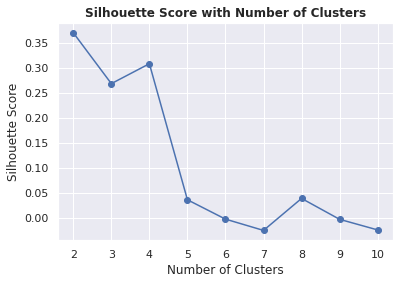

In [16]:
# Plot silhouette score
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(n_cl_list, ss_list, marker='o');
ax.set(xlabel='Number of Clusters', ylabel = 'Silhouette Score');
ax.set_title('Silhouette Score with Number of Clusters',
             fontsize=12, weight='bold', ha='center');
#fig.savefig('outputs/figures/clustering/ss.png',
#            bbox_inches="tight")

ss_test = pd.DataFrame(zip(n_cl_list, ss_list), columns=['n_cluster', 'ss'])
ss_test

Although the maximum SS is obtained with 2 clusters, there is a second peak at 4 clusters and the silhoeutte score only decreased slightly. For more informative clusters, I will visually inspect the profile of the clusters when more clusters are used.

In [17]:
# Perform clustering
n_cl = 4

km_cluster = KMeans(n_clusters=n_cl, n_init=500).fit(exp_var_std)
cluster_label = km_cluster.labels_

In [18]:
# Set up dict to manually re-label clusters for consistency
cl_relabel = {}
stn_list = ['Aldgate', 'Baker Street', 'Angel', 'Acton Town']
for i in range(len(stn_list)):
    # Find assigned cluster label
    assigned_lab = cluster_label[np.where(exp_var_std.index == stn_list[i])]
    cl_relabel[assigned_lab[0]] = i+1

In [19]:
# Create df of stations and reassigned cluster label
cluster_df =\
    pd.DataFrame(zip(exp_var_std.index, cluster_label),
                 columns=[exp_var_std.index.name, 'Cluster'])
cluster_df['Cluster'] = cluster_df['Cluster'].map(cl_relabel)

In [20]:
for i in set(cluster_df['Cluster']):
    print(f"There are {sum(cluster_df['Cluster']==i)} stations in Cluster {i}.")

There are 26 stations in Cluster 1.
There are 36 stations in Cluster 2.
There are 74 stations in Cluster 3.
There are 129 stations in Cluster 4.


In [21]:
# Get cluster centroid
cluster_centroid = pd.DataFrame(km_cluster.cluster_centers_,
                                columns=exp_var_std.columns)
cluster_centroid.index = cluster_centroid.index.map(cl_relabel)
avg_centroid = exp_var_std.mean()

# Make Sense of Clusters

## Create functions for scalability

In [22]:
# Set color cycle and palette
col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
col_palette = {i+1: col_cycle[i] for i in range(n_cl)}
col_palette[3] = col_cycle[4]

In [23]:
# Path for saving figures and cluster name
cl_path = {1: 'commercial_core',
           2: 'touristic_transport_hub',
           3: 'inner_suburb',
           4: 'outer_suburb'}

In [24]:
# Create function to plot radar chart of cluster centroid
def radar_centroid(cl_centroid, average_centroid, col_pal, cl):

    '''
    Plot radar chart of cluster centroid

    :param cl_centroid: df of cluster centroids
    :param col_pal: color palette
    :param cl: cluster to plot
    :return the radar chart of cluster centroid
    '''

    # Number of variables
    var = cl_centroid.columns
    n_var = len(var)

    # Angle of axis
    angles = [n / float(n_var) * 2 * pi for n in range(n_var)]
    angles += angles[:1]

    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], var)
    ax.tick_params(labelsize=14);

    # Draw ylabels
    y_min = floor(min(cl_centroid.min()))
    y_max = ceil(max(cl_centroid.max()))
    plt.ylim(y_min, y_max)

    # Plot average
    values = list(average_centroid)
    values += values[:1]
    ax.plot(angles, values, linewidth=1.5, color='dimgrey',
            linestyle=':', label="Average")

    # Plot cluster centroid
    values = cl_centroid.loc[cl, :].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=col_pal[cl], 
            linewidth=1.5, linestyle='--', marker="o", label=f"Cluster {cl}")
    ax.fill(angles, values, color=col_pal[cl], alpha=0.1)

    # Styling
    ax.set_title(f"Cluster Centroid",
                 fontsize=20, weight='bold');
    plt.legend(loc='upper right', bbox_to_anchor=(0.15, 0.15),
               fontsize=14)

    return fig

In [25]:
# Create function to plot clusters average journey profile
def avg_demand_profile(df_throughput, df_entry, df_exit, cl_lab, col_pal, cl):

    '''
    Plot the average demand profile of stations in cluster

    :param df_throughput: df of throughput
    :param df_entry: df of entry
    :param df_exit: df of entry
    :param cl_lab: df of stations and cluster labels
    :param col_pal: color palette
    :param cl: cluster to plot
    :return the plot of average journey profile of throughout, entries and exits
    '''

    fig, ax = plt.subplots(1, 3, figsize=(24, 5),
                           sharex='col', sharey='row')

    entex_label = {0: 'throughput',
                   1: 'entry',
                   2: 'exit'}

    # Get stations in cluster
    stn = cl_lab.loc[cl_lab['Cluster'] == cl, 'StationName']

    for entex_ax in range(3):

        # Get data for plotting
        plot_data = locals()['df_' + entex_label[entex_ax]]
        plot_data = plot_data.loc[stn, :]

        # Plot station data
        ax[entex_ax].plot(plot_data.T.index, plot_data.T, c="gray", alpha=0.2);
        ax[entex_ax].plot(plot_data.T.index, plot_data.mean(),
                          c=col_pal[cl], linewidth=2.5);

        # Styling
        ax[entex_ax].set_xticks(range(0, len(plot_data.columns), 8));
        ax[entex_ax].tick_params(axis='x', rotation=315, labelsize=16);
        ax[entex_ax].set_title(f"{entex_label[entex_ax].capitalize()}",
                               fontsize=22, weight='bold');
        ax[entex_ax].set_xlabel('Time', size=18, labelpad=12)
    
    ax[0].set_ylabel('Proportion', size=18, labelpad=12)
    ax[0].tick_params(axis='y', labelsize=16);

    fig.tight_layout()

    return fig

In [26]:
# Create function to plot location of stations in cluster
def cluster_loc(inner_gdf, caz_gdf,
                line_gdf, station_gdf, col_pal,
                cl_lab, cl):

    '''
    Plot the locations of stations in cluster

    :param inner_gdf: gdf of Inner London
    :param caz_gdf: gdf of CAZ
    :param line_gdf: gdf of underground lines
    :param station_gdf: gdf of stations
    :param col_pal: color palette
    :param cl_lab: cluster labels
    :param cl: cluster to plot
    :return the plot of location of stations in cluster
    '''

    fig, ax = plt.subplots(figsize=(18, 15))

    # Get stations in cluster
    stn = cl_lab.loc[cl_lab['Cluster'] == cl, 'StationName']

    # Plot outlines of London, Inner London and CAZ
    inner_gdf.plot(ax=ax, facecolor='none', edgecolor='saddlebrown',
                   lw=1.5, ls='--')
    caz_gdf.plot(ax=ax, facecolor='none', edgecolor='maroon',
                 lw=1.5, ls='--')
    
    inner_leg = mlines.Line2D([], [],
                              color='saddlebrown',
                              linestyle='--', linewidth=1.5,
                              label='Inner London')
    caz_leg = mlines.Line2D([], [],
                            color='maroon',
                            linestyle='--', linewidth=1.5,
                            label='CAZ')
    ax.legend(handles=[inner_leg, caz_leg], fontsize=16, title_fontsize=16)

    # Plot underground lines
    line_gdf.plot(ax=ax, linewidth=0.8)

    # Plot stations
    plot_data = station_gdf[station_gdf['name'].isin(stn)]
    plot_data.plot(ax=ax, markersize=65, 
                   facecolor=col_pal[cl])

    data_null = stations_gdf[~station_gdf['name'].isin(stn)]
    data_null.plot(ax=ax, markersize=50, 
                   facecolor='white', edgecolor='black')

    ax.set_title(f"Location of Stations",
                 fontsize=22, weight='bold');

    # Add base map
    cx.add_basemap(ax, crs=station_gdf.crs,
                   source=cx.providers.CartoDB.PositronNoLabels)

    # Add north arrow, https://stackoverflow.com/a/58110049/604456
    x, y, arrow_length = 0.9, 0.14, 0.08
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=10),
                ha='center', va='center', fontsize=16,
                xycoords=ax.transAxes)

    # Add scale-bar
    x, y, scale_len = 546000, 170000, 5000
    scale_rect = matplotlib.patches.Rectangle((x, y), scale_len, 200,
                                              linewidth=1, edgecolor='k',
                                              facecolor='k')
    ax.add_patch(scale_rect)
    plt.text(x+scale_len/2, y+400, s='5 KM',
             fontsize=16, horizontalalignment='center')

    ax.set_axis_off()

    return fig

## Cluster 1: Commercial Core

26 stations in Cluster 1: ['Aldgate', 'Aldgate East', 'Bank and Monument', 'Barbican', 'Blackfriars LU', 'Cannon Street LU', 'Chancery Lane', 'Charing Cross LU', 'Covent Garden', 'Embankment', 'Farringdon', 'Goodge Street', 'Holborn', 'Leicester Square', 'Liverpool Street LU', 'London Bridge LU', 'Mansion House', 'Moorgate', 'Oxford Circus', 'Piccadilly Circus', "Regent's Park", "St. James's Park", "St. Paul's", 'Temple', 'Tottenham Court Road', 'Tower Hill']


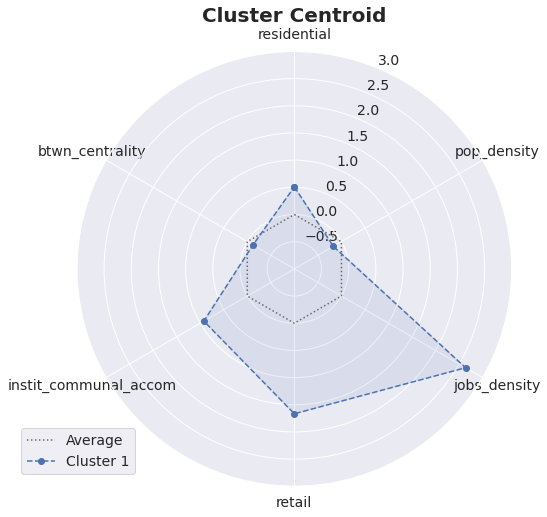

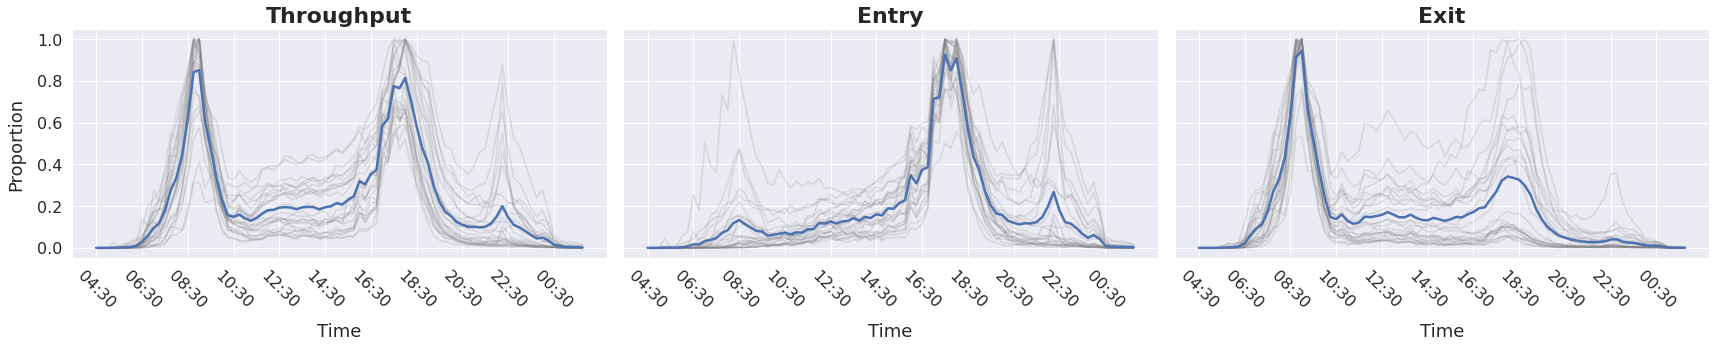

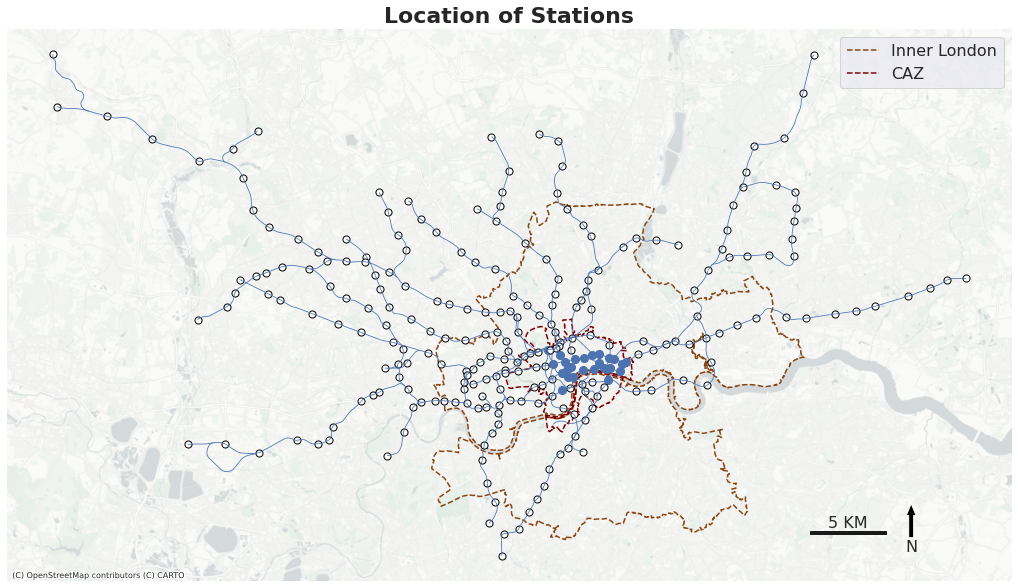

In [27]:
cl_curr = 1

# Radar plot
cl_radar = radar_centroid(cl_centroid=cluster_centroid,
                          average_centroid=avg_centroid,
                          col_pal=col_palette, cl=cl_curr)
#cl_radar.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/radar.png",
#                 bbox_inches="tight")

# Average journey profile
cl_demand = avg_demand_profile(df_throughput=throughput_std,
                               df_entry=entry_std,
                               df_exit=exit_std,
                               cl_lab=cluster_df,
                               col_pal=col_palette,
                               cl=cl_curr)
#cl_demand.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/demand.png",
#                  bbox_inches="tight")

# Location of stations
cl_loc = cluster_loc(inner_gdf=inner_london_gdf, caz_gdf=caz_gdf,
                     line_gdf=lines_gdf, station_gdf=stations_gdf, 
                     col_pal=col_palette,
                     cl_lab=cluster_df, cl=cl_curr)
#cl_loc.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/location.png",
#               bbox_inches="tight")

stn_curr = list(cluster_df.loc[cluster_df['Cluster'] == cl_curr, 'StationName'])
print(f"{len(stn_curr)} stations in Cluster {cl_curr}: {stn_curr}")

## Cluster 2: Touristic and Transport Hub

36 stations in Cluster 2: ['Baker Street', 'Bayswater', 'Bethnal Green LU', 'Bond Street', "Earl's Court", 'Edgware Road', 'Euston LU', 'Finchley Road', 'Gloucester Road', 'Great Portland Street', 'Green Park', 'High Street Kensington', 'Holland Park', 'Hyde Park Corner', "King's Cross St. Pancras", 'Knightsbridge', 'Ladbroke Grove', 'Lancaster Gate', 'Maida Vale', 'Marble Arch', 'Marylebone LU', 'Mile End', 'Notting Hill Gate', 'Paddington TfL', 'Pimlico', 'Queensway', 'Royal Oak', 'Sloane Square', 'South Kensington', 'Stratford', 'Victoria LU', 'Warren Street', 'Warwick Avenue', 'Waterloo LU', 'Westbourne Park', 'Westminster']


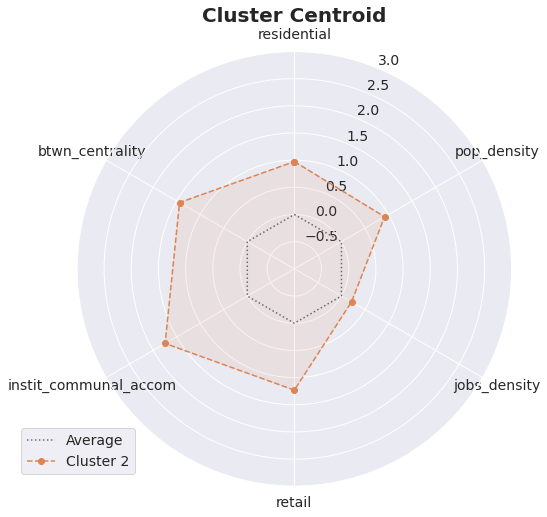

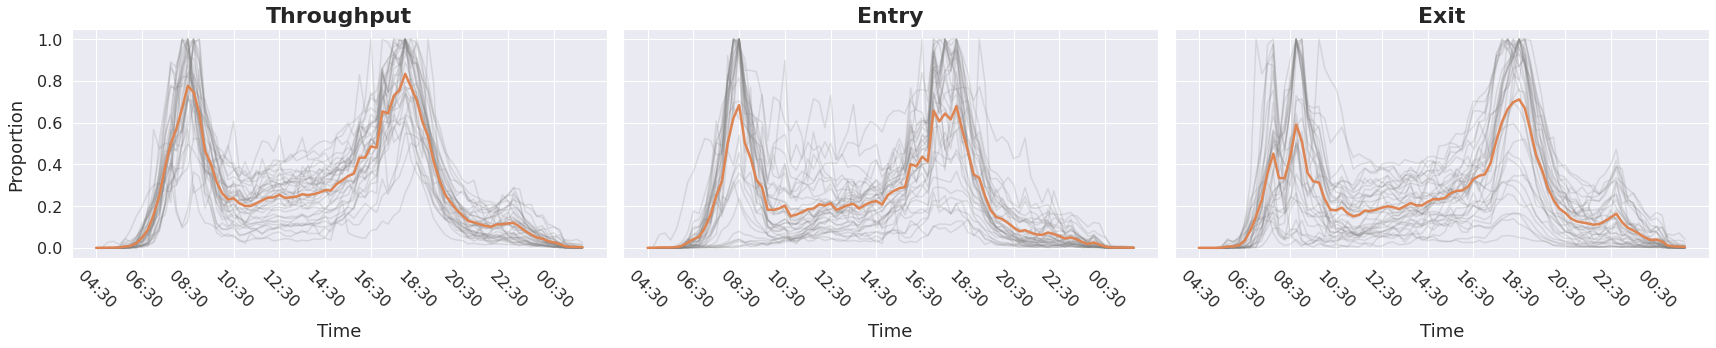

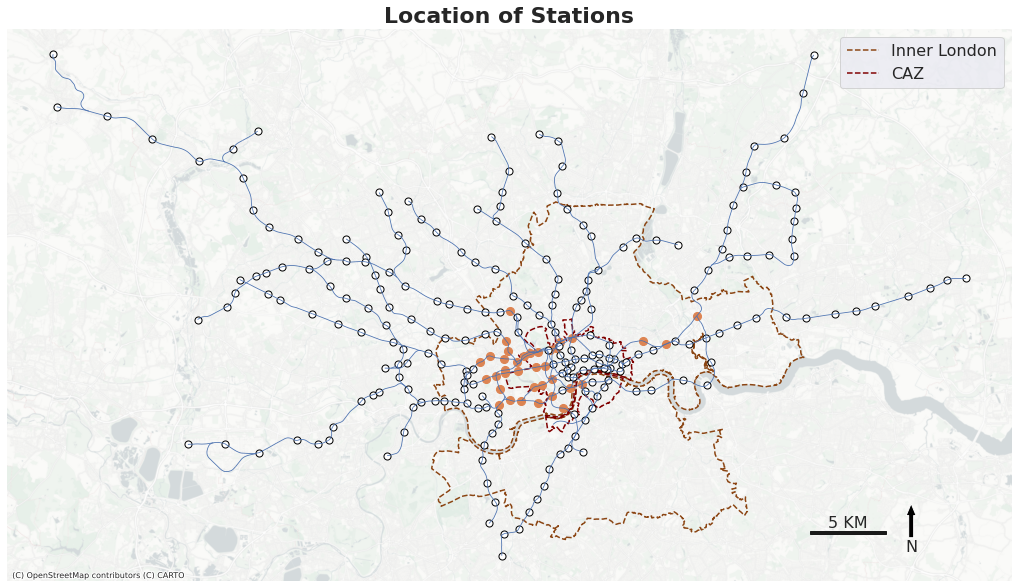

In [28]:
cl_curr = 2

# Radar plot
cl_radar = radar_centroid(cl_centroid=cluster_centroid,
                          average_centroid=avg_centroid,
                          col_pal=col_palette, cl=cl_curr)
#cl_radar.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/radar.png",
#                 bbox_inches="tight")

# Average journey profile
cl_demand = avg_demand_profile(df_throughput=throughput_std,
                               df_entry=entry_std,
                               df_exit=exit_std,
                               cl_lab=cluster_df,
                               col_pal=col_palette,
                               cl=cl_curr)
#cl_demand.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/demand.png",
#                  bbox_inches="tight")

# Location of stations
cl_loc = cluster_loc(inner_gdf=inner_london_gdf, caz_gdf=caz_gdf,
                     line_gdf=lines_gdf, station_gdf=stations_gdf, 
                     col_pal=col_palette,
                     cl_lab=cluster_df, cl=cl_curr)
#cl_loc.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/location.png",
#               bbox_inches="tight")

stn_curr = list(cluster_df.loc[cluster_df['Cluster'] == cl_curr, 'StationName'])
print(f"{len(stn_curr)} stations in Cluster {cl_curr}: {stn_curr}")

## Cluster 3: Inner Suburb

74 stations in Cluster 3: ['Angel', 'Archway', 'Arsenal', 'Balham LU', 'Barons Court', 'Belsize Park', 'Bermondsey', 'Borough', 'Bow Road', 'Brixton LU', 'Bromley-by-Bow', 'Caledonian Road', 'Camden Town', 'Canada Water', 'Canary Wharf LU', 'Canning Town', 'Chalk Farm', 'Clapham Common', 'Clapham North', 'Clapham South', 'East Ham', 'East Putney', 'Elephant & Castle LU', 'Euston Square', 'Finsbury Park', 'Fulham Broadway', 'Goldhawk Road', 'Hammersmith', 'Hampstead', 'Highbury & Islington', 'Holloway Road', 'Kennington', 'Kensal Green', 'Kensington (Olympia)', 'Kentish Town', 'Kilburn', 'Kilburn Park', 'Lambeth North', 'Latimer Road', 'Leyton', 'Manor House', 'Mornington Crescent', 'Old Street', 'Oval', 'Parsons Green', 'Plaistow', 'Putney Bridge', "Queen's Park", 'Ravenscourt Park', 'Russell Square', 'Seven Sisters', "Shepherd's Bush LU", "Shepherd's Bush Market", 'Southfields', 'Southwark', "St. John's Wood", 'Stepney Green', 'Stockwell', 'Swiss Cottage', 'Tooting Bec', 'Tooting Broa

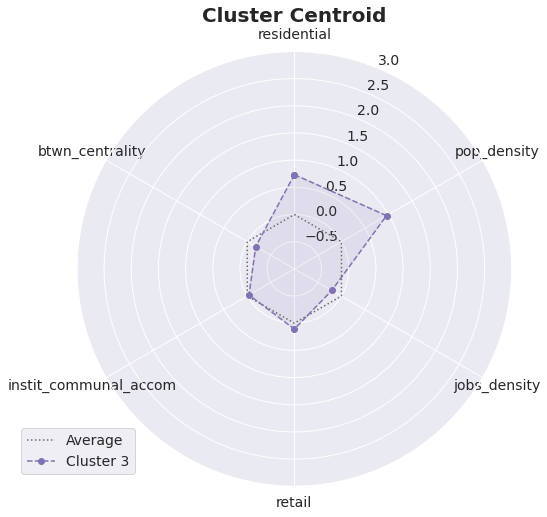

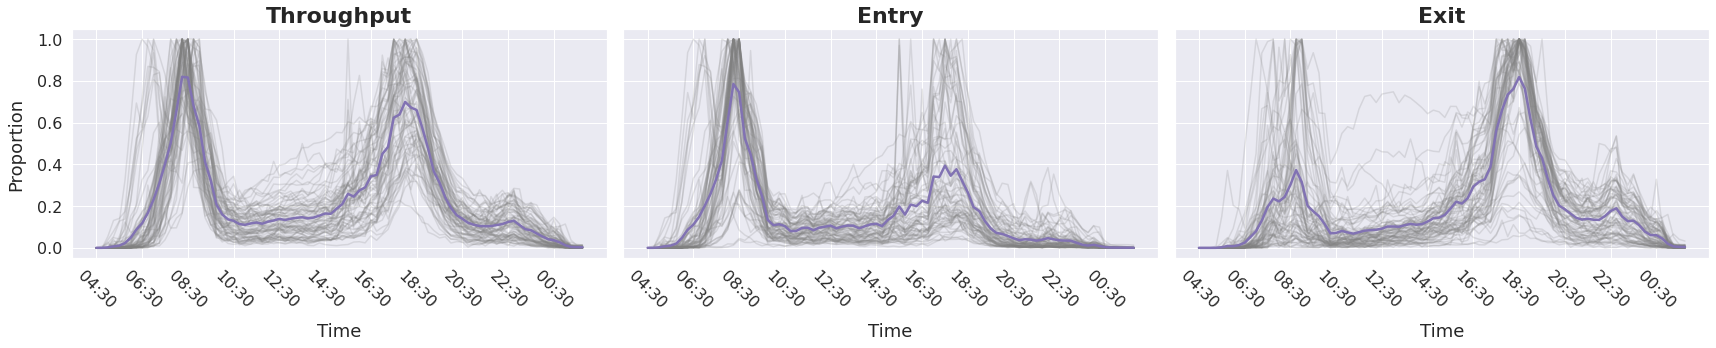

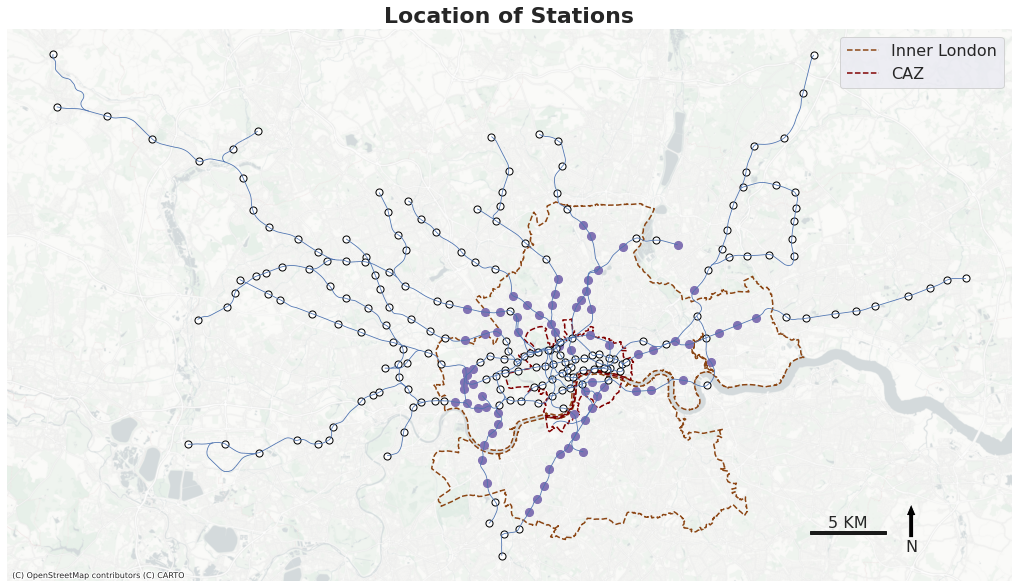

In [29]:
cl_curr = 3

# Radar plot
cl_radar = radar_centroid(cl_centroid=cluster_centroid,
                          average_centroid=avg_centroid,
                          col_pal=col_palette, cl=cl_curr)
#cl_radar.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/radar.png",
#                 bbox_inches="tight")

# Average journey profile
cl_demand = avg_demand_profile(df_throughput=throughput_std,
                               df_entry=entry_std,
                               df_exit=exit_std,
                               cl_lab=cluster_df,
                               col_pal=col_palette,
                               cl=cl_curr)
#cl_demand.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/demand.png",
#                  bbox_inches="tight")

# Location of stations
cl_loc = cluster_loc(inner_gdf=inner_london_gdf, caz_gdf=caz_gdf,
                     line_gdf=lines_gdf, station_gdf=stations_gdf, 
                     col_pal=col_palette,
                     cl_lab=cluster_df, cl=cl_curr)
#cl_loc.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/location.png",
#               bbox_inches="tight")

stn_curr = list(cluster_df.loc[cluster_df['Cluster'] == cl_curr, 'StationName'])
print(f"{len(stn_curr)} stations in Cluster {cl_curr}: {stn_curr}")

## Cluster 4: Outer Suburbs

129 stations in Cluster 4: ['Acton Town', 'Alperton', 'Amersham', 'Arnos Grove', 'Barking', 'Barkingside', 'Becontree', 'Blackhorse Road', 'Boston Manor', 'Bounds Green', 'Brent Cross', 'Buckhurst Hill', 'Burnt Oak', 'Canons Park', 'Chalfont & Latimer', 'Chesham', 'Chigwell', 'Chiswick Park', 'Chorleywood', 'Cockfosters', 'Colindale', 'Colliers Wood', 'Croxley', 'Dagenham East', 'Dagenham Heathway', 'Debden', 'Dollis Hill', 'Ealing Broadway', 'Ealing Common', 'East Acton', 'East Finchley', 'Eastcote', 'Edgware', 'Elm Park', 'Epping', 'Fairlop', 'Finchley Central', 'Gants Hill', 'Golders Green', 'Grange Hill', 'Greenford', 'Gunnersbury', 'Hainault', 'Hanger Lane', 'Harlesden', 'Harrow & Wealdstone', 'Harrow-on-the-Hill', 'Hatton Cross', 'Heathrow Terminal 5 LU', 'Heathrow Terminals 123 LU', 'Hendon Central', 'High Barnet', 'Highgate', 'Hillingdon', 'Hornchurch', 'Hounslow Central', 'Hounslow East', 'Hounslow West', 'Ickenham', 'Kenton', 'Kew Gardens', 'Kingsbury', 'Leytonstone', 'Lought

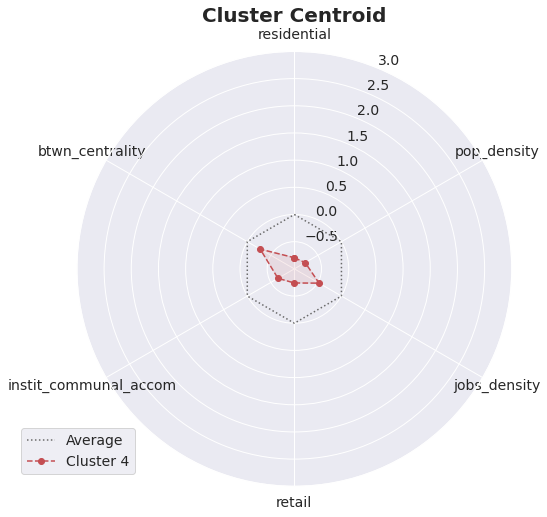

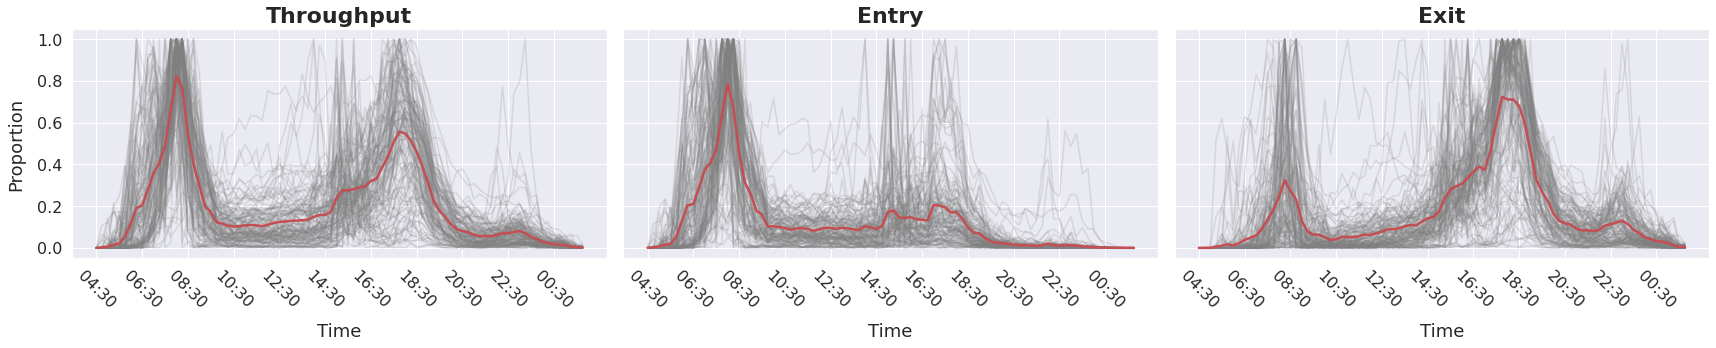

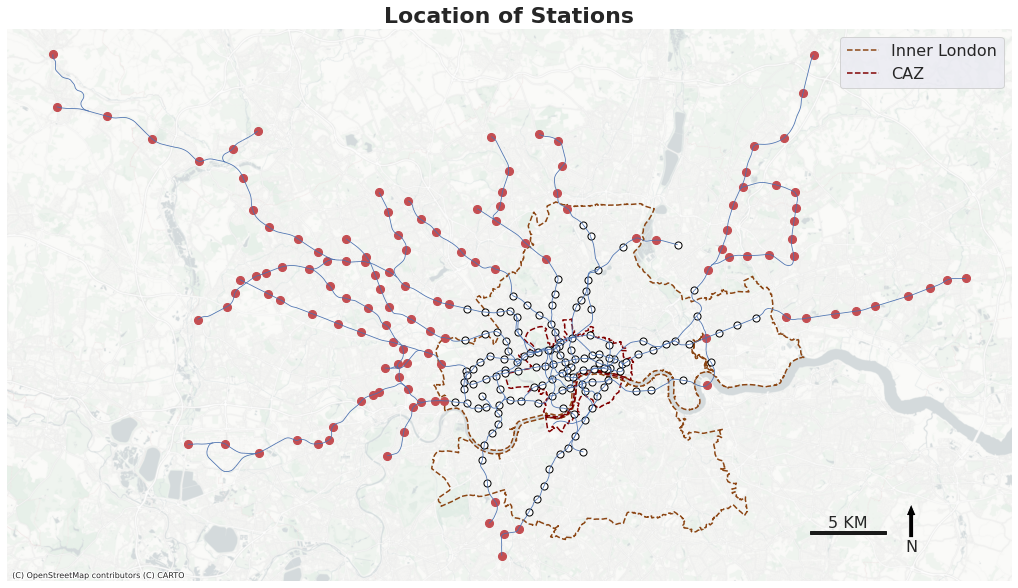

In [30]:
cl_curr = 4

# Radar plot
cl_radar = radar_centroid(cl_centroid=cluster_centroid,
                          average_centroid=avg_centroid,
                          col_pal=col_palette, cl=cl_curr)
#cl_radar.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/radar.png",
#                 bbox_inches="tight")

# Average journey profile
cl_demand = avg_demand_profile(df_throughput=throughput_std,
                               df_entry=entry_std,
                               df_exit=exit_std,
                               cl_lab=cluster_df,
                               col_pal=col_palette,
                               cl=cl_curr)
#cl_demand.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/demand.png",
#                  bbox_inches="tight")

# Location of stations
cl_loc = cluster_loc(inner_gdf=inner_london_gdf, caz_gdf=caz_gdf,
                     line_gdf=lines_gdf, station_gdf=stations_gdf, 
                     col_pal=col_palette,
                     cl_lab=cluster_df, cl=cl_curr)
#cl_loc.savefig(f"outputs/figures/clustering/{cl_path[cl_curr]}/location.png",
#               bbox_inches="tight")

stn_curr = list(cluster_df.loc[cluster_df['Cluster'] == cl_curr, 'StationName'])
print(f"{len(stn_curr)} stations in Cluster {cl_curr}: {stn_curr}")

# Compare Gini and Gamma of Clusters

In [31]:
# Map cluster name
cl_name = {1: 'Commercial Core',
           2: 'Touristic and Transport Hub',
           3: 'Inner Suburb',
           4: 'Outer Suburb'}

cluster_df['Cluster_Name'] = cluster_df['Cluster'].map(cl_name)

In [32]:
cluster_df.head()

StationName  Cluster     Cluster_Name
0    Acton Town        4     Outer Suburb
1       Aldgate        1  Commercial Core
2  Aldgate East        1  Commercial Core
3      Alperton        4     Outer Suburb
4      Amersham        4     Outer Suburb

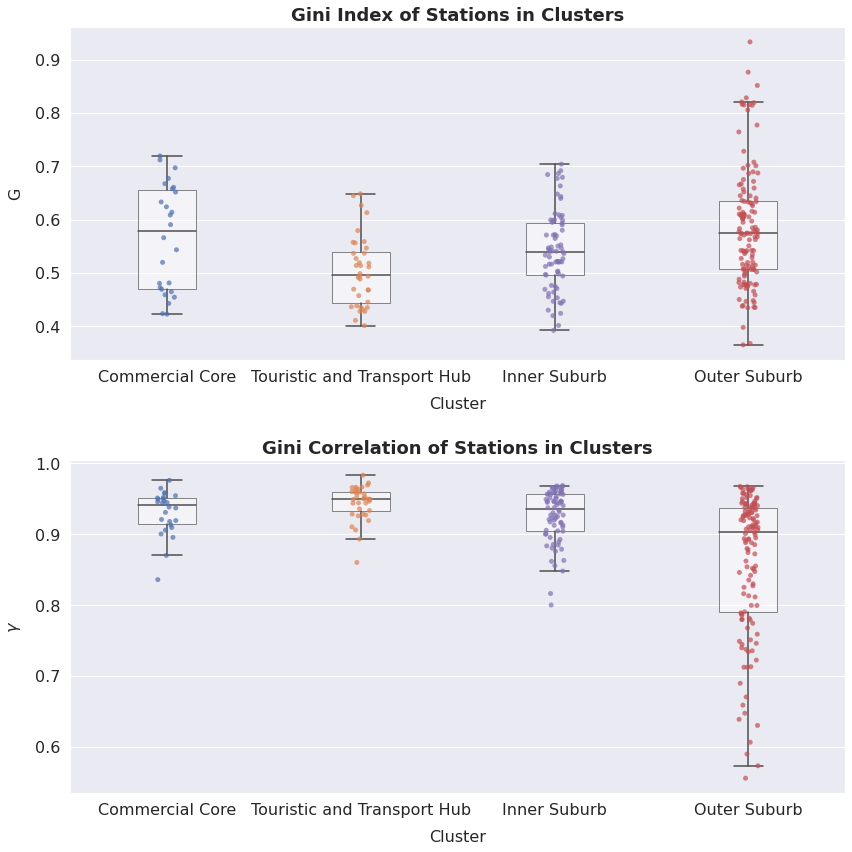

In [33]:
fig, ax = plt.subplots(2, figsize=(12, 12))

# Mapper for measures to axis
ax_map = {0: 'gini', 1: 'gamma'}

for ax_id in range(len(ax_map)):

    measure = ax_map[ax_id]
    
    # Get values of measure and merge cluster label
    plot_data = pd.merge(stn_conc, cluster_df, on='StationName')

    # Plot data
    sns.stripplot(data=plot_data, x='Cluster', y=measure,
                  palette=col_palette.values(), ax=ax[ax_id],
                  alpha=0.7, jitter=0.05)
    sns.boxplot(data=plot_data, x='Cluster', y=measure,
                ax=ax[ax_id],
                width=0.3,
                boxprops=dict(linewidth=1, facecolor='w', edgecolor='k', alpha=0.5),
                showfliers=False)
    ax[ax_id].set_xlabel('Cluster', fontsize=16, labelpad=12)
    ax[ax_id].set_xticklabels(cl_name.values(), size=16)
    ax[ax_id].tick_params(labelsize=16);

ax[0].set_title("Gini Index of Stations in Clusters",
                fontsize=18, weight='bold')
ax[0].set_ylabel("G", fontsize=16, labelpad=12)

ax[1].set_title("Gini Correlation of Stations in Clusters",
                fontsize=18, weight='bold')
ax[1].set_ylabel(r"$\gamma$", fontsize=16, labelpad=12)

fig.tight_layout()
plt.subplots_adjust(hspace=0.3)

#fig.savefig("outputs/figures/clustering/cluster_comparison.png",
#            bbox_inches="tight")

# Save Outputs

In [34]:
#cluster_df.to_csv('outputs/stn_data/features_and_cluster/stn_cluster.csv',
#                  index=False)